In [18]:
import re
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting

# importing rmaps

In [31]:
network_interest = "dmn"
connectivity_maps = glob.glob("mcinet_task_memory/rmap_seeds/*sub*_"+network_interest+".nii.gz")
len(connectivity_maps)

87

# import csv file 

In [32]:
#load the csv files
cimaq_diagnostic = pd.read_csv('36448_diagnostic_clinique.tsv', sep = '\t')
cimaq_diagnostic
print(set(cimaq_diagnostic['36448_diagnostic_clinique'].values))

#Rename the columns
cimaq_diagnostic = cimaq_diagnostic[['CandID','36448_diagnostic_clinique','Candidate_Age']]
cimaq_diagnostic.rename(columns = {"CandID":"subID","36448_diagnostic_clinique":"diagnostic","Candidate Age":"Age" },inplace=True)

#drop the rows that have nan
cimaq_diagnostic.dropna(inplace=True)

#drop the subjects that have AD
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]

#Get the subject IDs from the the rmaps
subjectID_set = set([sub.split("sub")[1].split("_")[0] for sub in connectivity_maps])
                    
#drop the subjects from csv if rmaps are not present
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]                   
                    
print(cimaq_diagnostic.shape)
cimaq_diagnostic.head()

{nan, 'troubles_subjectifs_de_cognition', 'démence_de_type_alzheimer-légère', 'trouble_cognitif_léger_tardif', 'cognitivement_sain_(cs)', 'trouble_cognitif_léger_précoce'}
(87, 3)


,subID,diagnostic,Candidate_Age
4,318809.0,cognitivement_sain_(cs),70.9
11,437101.0,cognitivement_sain_(cs),74.5
21,164965.0,cognitivement_sain_(cs),66.3
22,597569.0,trouble_cognitif_léger_précoce,67.9
23,484204.0,troubles_subjectifs_de_cognition,68


# create design matrix

In [33]:

cimaq_diagnostic["MCI"] = 0
cimaq_diagnostic["SCD"] = 0
cimaq_diagnostic["CN"] = 0

for i,r in cimaq_diagnostic.iterrows():
    
    #print(i)
    if(r["diagnostic"] == "troubles_subjectifs_de_cognition" ):
        cimaq_diagnostic.loc[i,"SCD"] = 1

    if(r["diagnostic"] == "cognitivement_sain_(cs)"):
        cimaq_diagnostic.loc[i,"CN"] = 1          

    if("trouble_cognitif_léger" in r["diagnostic"] ):
        cimaq_diagnostic.loc[i,"MCI"] = 1


    cimaq_diagnostic.loc[i,"subID"] = str(r["subID"]).split(".")[0]
    

# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]
# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
cimaq_diagnostic.head()

,subID,diagnostic,Candidate_Age,MCI,SCD,CN
4,318809,cognitivement_sain_(cs),70.9,0,0,1
11,437101,cognitivement_sain_(cs),74.5,0,0,1
21,164965,cognitivement_sain_(cs),66.3,0,0,1
22,597569,trouble_cognitif_léger_précoce,67.9,1,0,0
23,484204,troubles_subjectifs_de_cognition,68,0,1,0


In [34]:
design_matrix = cimaq_diagnostic[["MCI","SCD","CN"]]
design_matrix.shape

(87, 3)

# perform  t-test

In [35]:
#take the rmaps that are in the csv
second_level_input = []
for i in connectivity_maps:
    sub = re.search("\d\d\d\d\d\d",i)
    subid = sub.group(0)
    if(subid in set(cimaq_diagnostic["subID"].values)):        
        second_level_input.append(i)


In [36]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
z_score = second_level_model.compute_contrast(second_level_contrast = [0,-1,1])


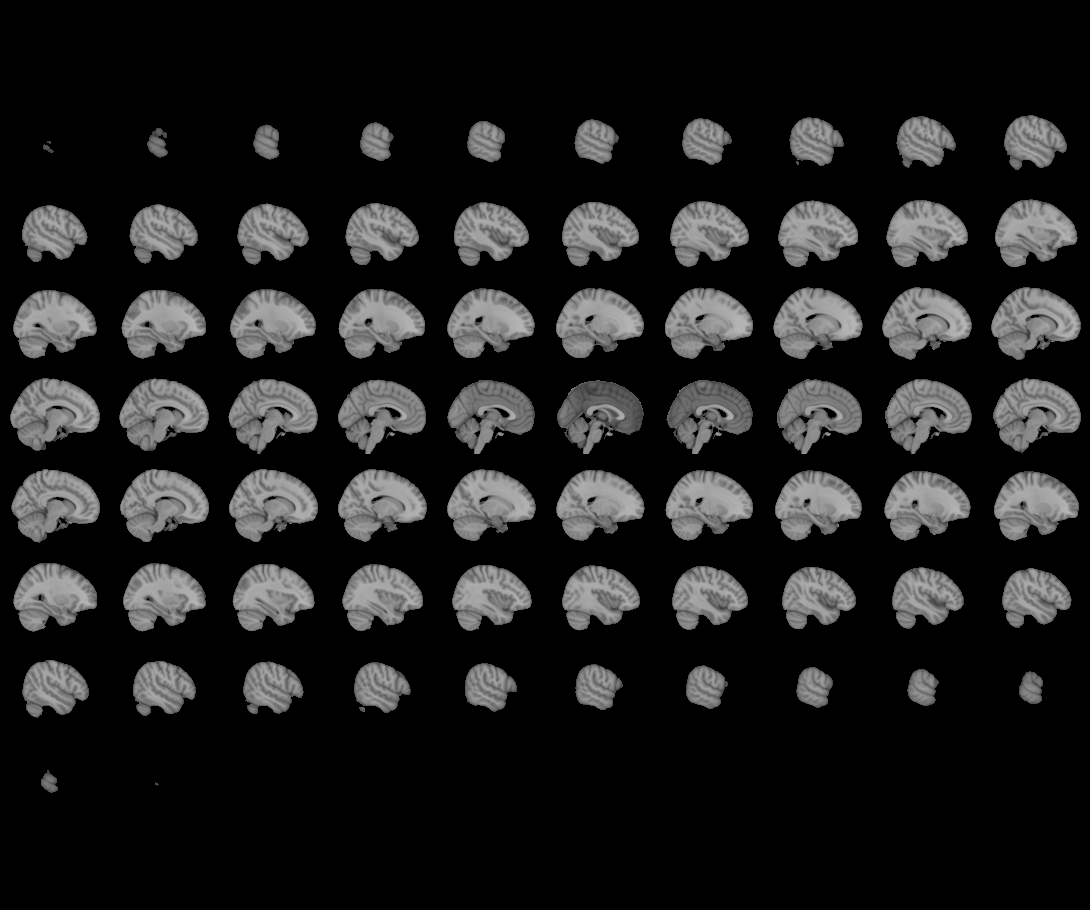
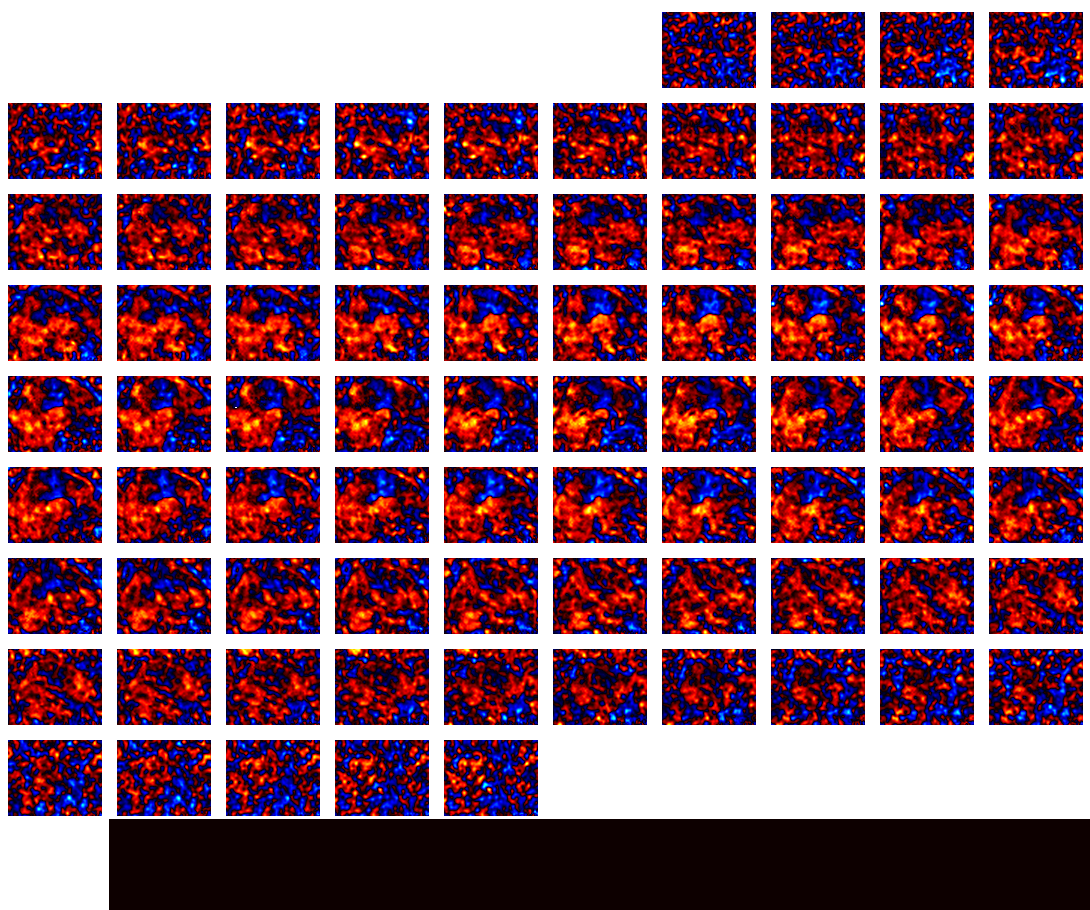

In [37]:
plotting.view_img(z_score)

/home/hanads/.local/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:71: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1e-06 
  threshold))
/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))
/home/hanads/.local/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



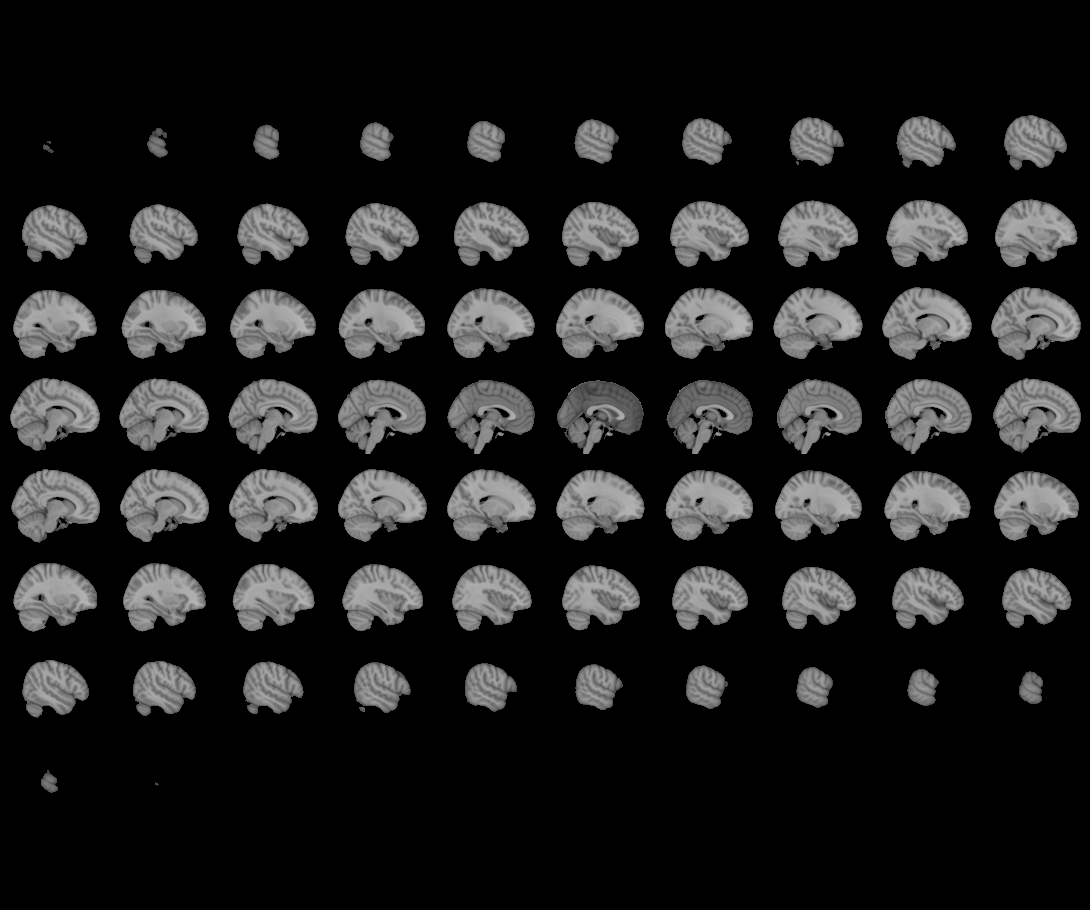
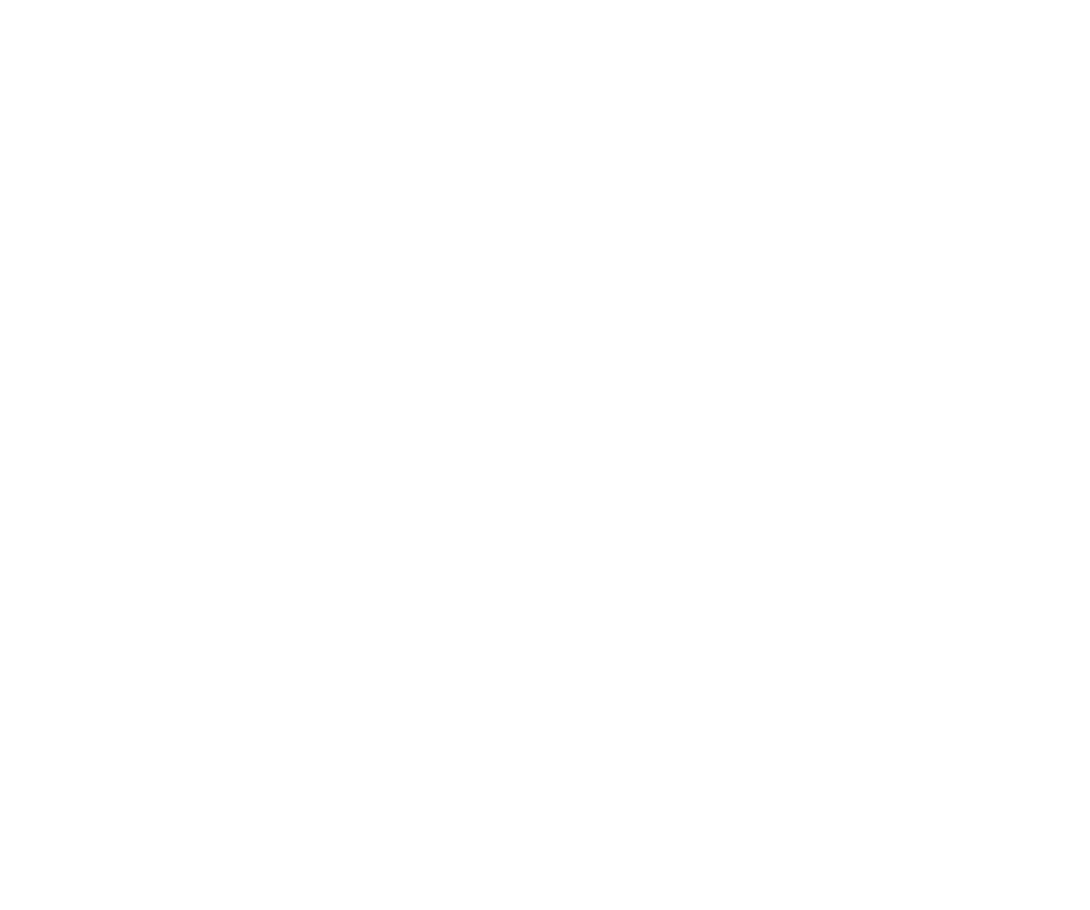

In [41]:
thresholded_map, threshold = map_threshold(z_score, alpha=0.4, height_control='fdr')
plotting.view_img(thresholded_map)